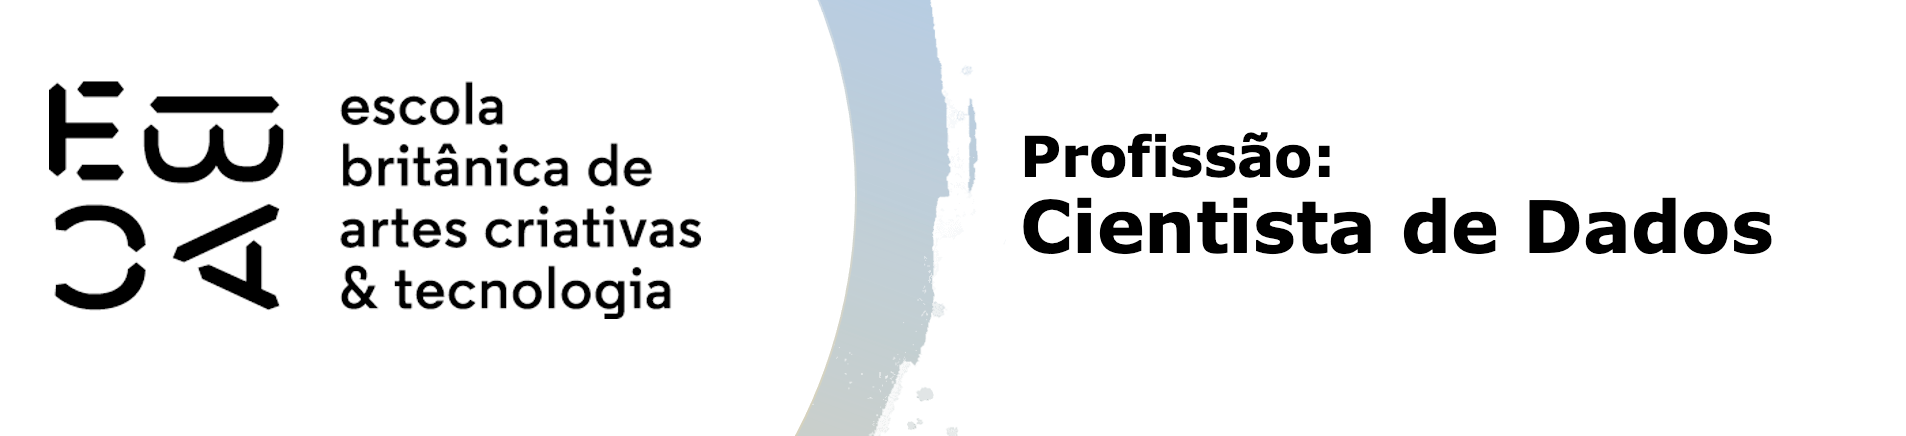

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import script

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from pycaret.classification import *

%reload_ext watermark
%watermark -iv -v

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.20.0

scipy     : 1.11.4
sklearn   : 1.4.2
numpy     : 1.26.3
matplotlib: 3.7.5
pandas    : 2.2.0
seaborn   : 0.12.2



In [2]:
# Dicionário dos Meses.

meses = {1:  'Jan',
         2:  'Fev',
         3:  'Mar',
         4:  'Abr',
         5:  'Mai',
         6:  'Jun',
         7:  'Jul',
         8:  'Ago',
         9:  'Set',
         10: 'Out',
         11: 'Nov',
         12: 'Dez'}

In [3]:
# Carregando o DataFrame e Tratamento inicial.

df = pd.read_feather('credit_scoring.ftr')
df.set_index(keys='data_ref', inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.drop(columns='index', inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Separar os três últimos meses para validação out of time (oot)

df_valid = df.loc[df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]
df = df.loc[~df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Número de linhas para cada mês tanto do Treino quanto do Teste.

print(f'\033[1;92mDF:\033[0;1m\n{df.index.value_counts()}')
print('-'*25)
print(f'\033[1;94mDF_VALID:\033[0;1m{df_valid.index.value_counts()}')

DF:
data_ref
Jan_2015    50000
Fev_2015    50000
Mar_2015    50000
Abr_2015    50000
Mai_2015    50000
Jun_2015    50000
Jul_2015    50000
Ago_2015    50000
Set_2015    50000
Out_2015    50000
Nov_2015    50000
Dez_2015    50000
Name: count, dtype: int64
-------------------------
DF_VALID:data_ref
Jan_2016    50000
Fev_2016    50000
Mar_2016    50000
Name: count, dtype: int64


In [6]:
# Variáveis Quantitativas

df.describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.433210,0.739869,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,600000.0,43.798530,11.230659,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,499125.0,7.747992,6.688576,0.117808,3.049315,6.046575,10.180822,4.290685e+01
qt_pessoas_residencia,600000.0,2.212122,0.903757,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,600000.0,27222.844732,87377.875997,161.860000,4670.600000,9887.580000,21628.870000,4.083986e+06


In [7]:
# Variáveis Qualitativas

df.describe(include=['object']).T

,count,unique,top,freq
sexo,600000,2,F,403805
posse_de_veiculo,600000,2,N,366293
posse_de_imovel,600000,2,S,403054
tipo_renda,600000,5,Assalariado,308460
educacao,600000,5,Médio,405449
estado_civil,600000,5,Casado,421149
tipo_residencia,600000,6,Casa,539336


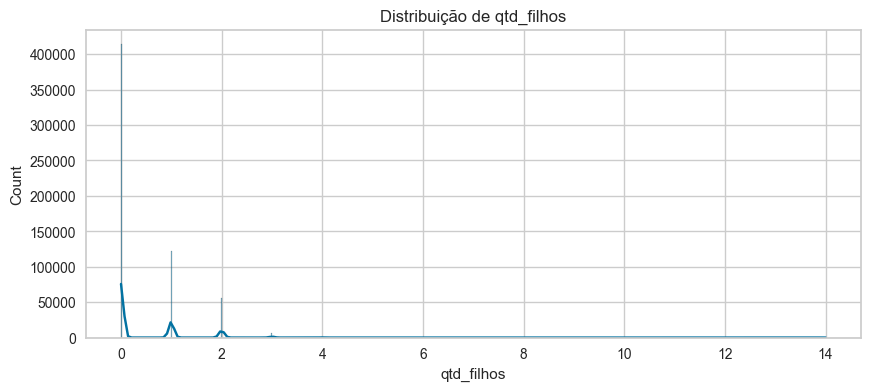

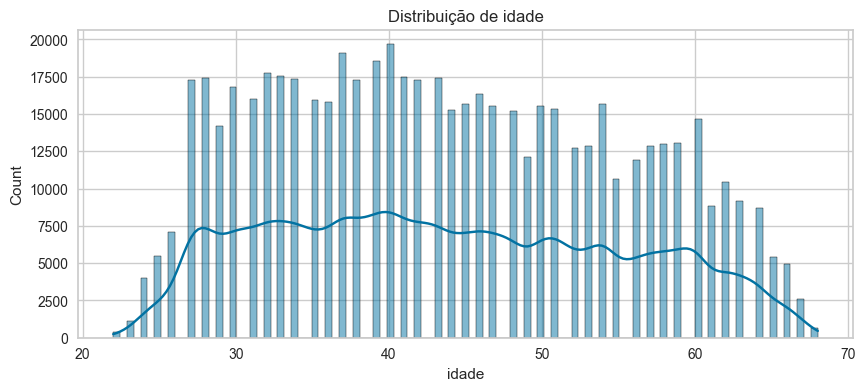

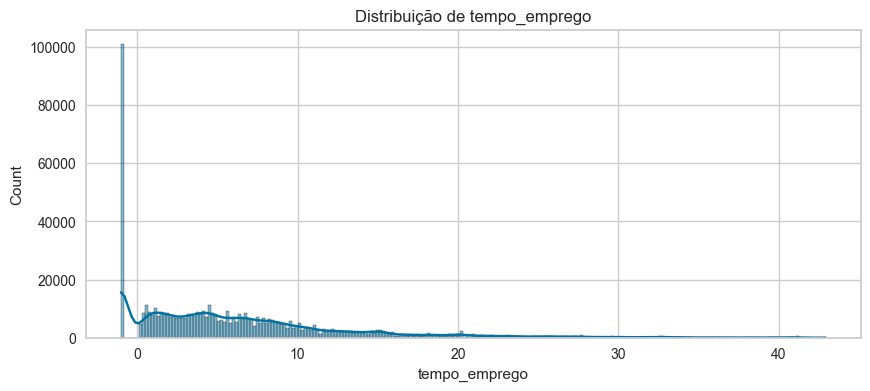

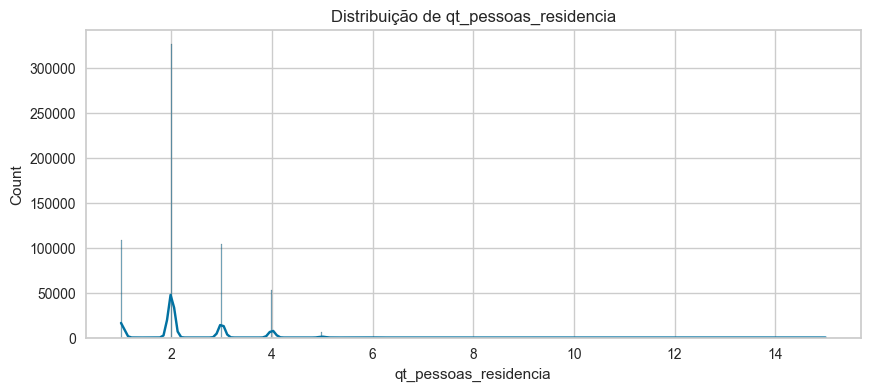

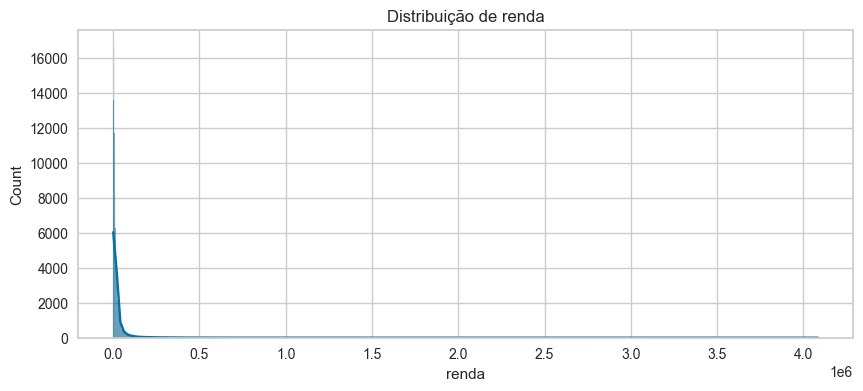

In [8]:
# Criando um histplot para cada Variável Quantitativa.

for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df.fillna({'tempo_emprego': -1}), x=col, kde=True)
    plt.title('Distribuição de ' + col)
    plt.show()

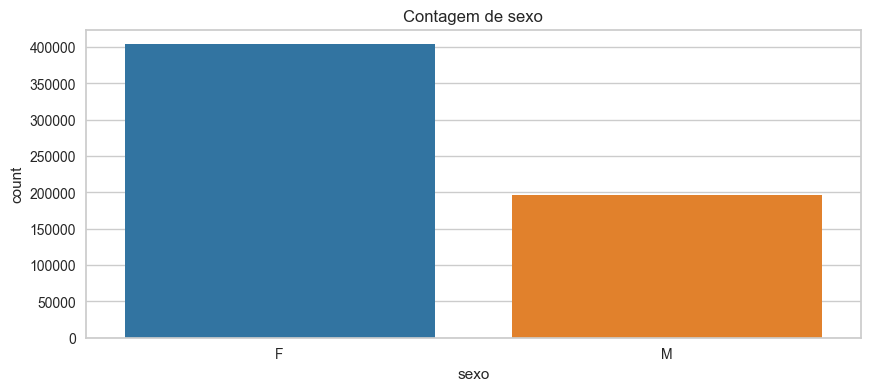

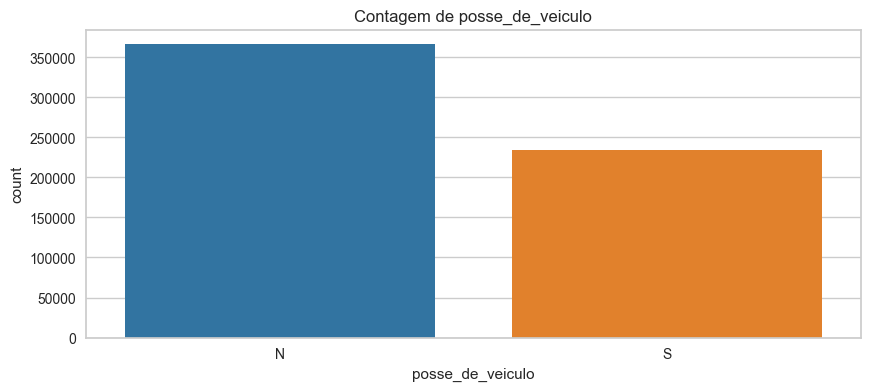

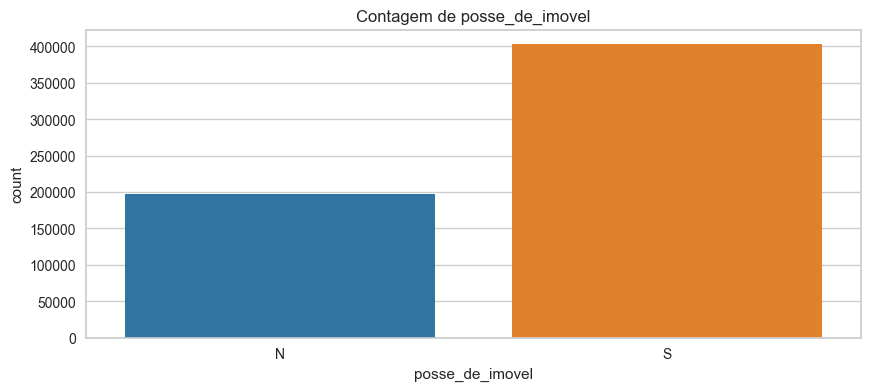

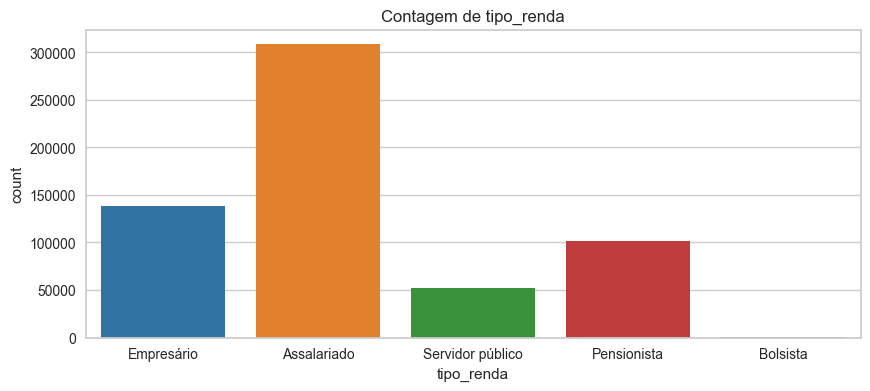

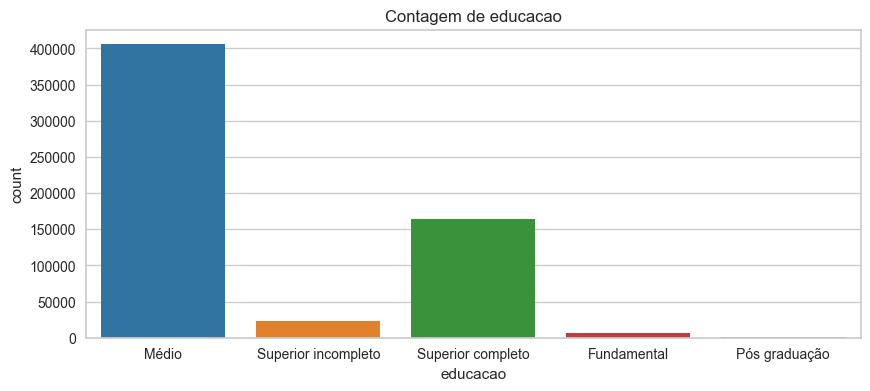

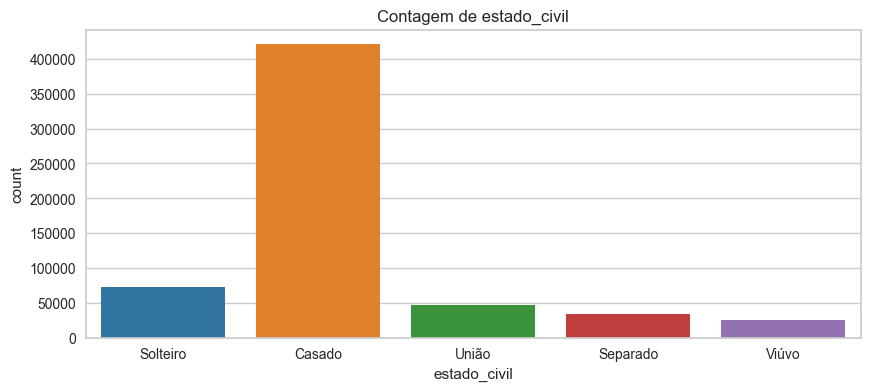

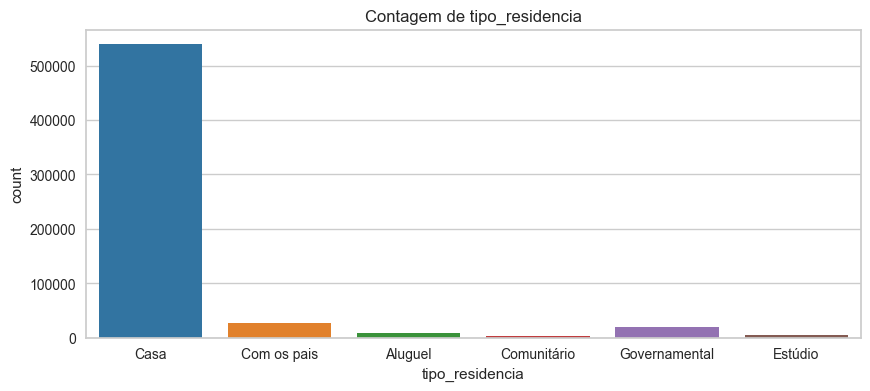

In [9]:
# Criando um countplot para cada Variável Quantitativa.

for col in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, palette="tab10")
    plt.title('Contagem de ' + col)
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

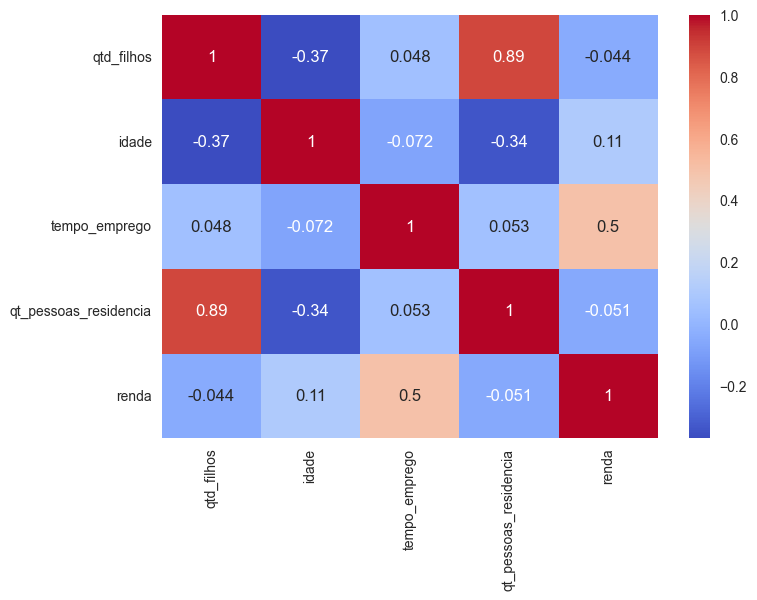

In [10]:
# Calculando a matriz de correlação
correlation_matrix = df.fillna({'tempo_emprego': -1}).select_dtypes(include='number').corr()

# Criando um heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.show()

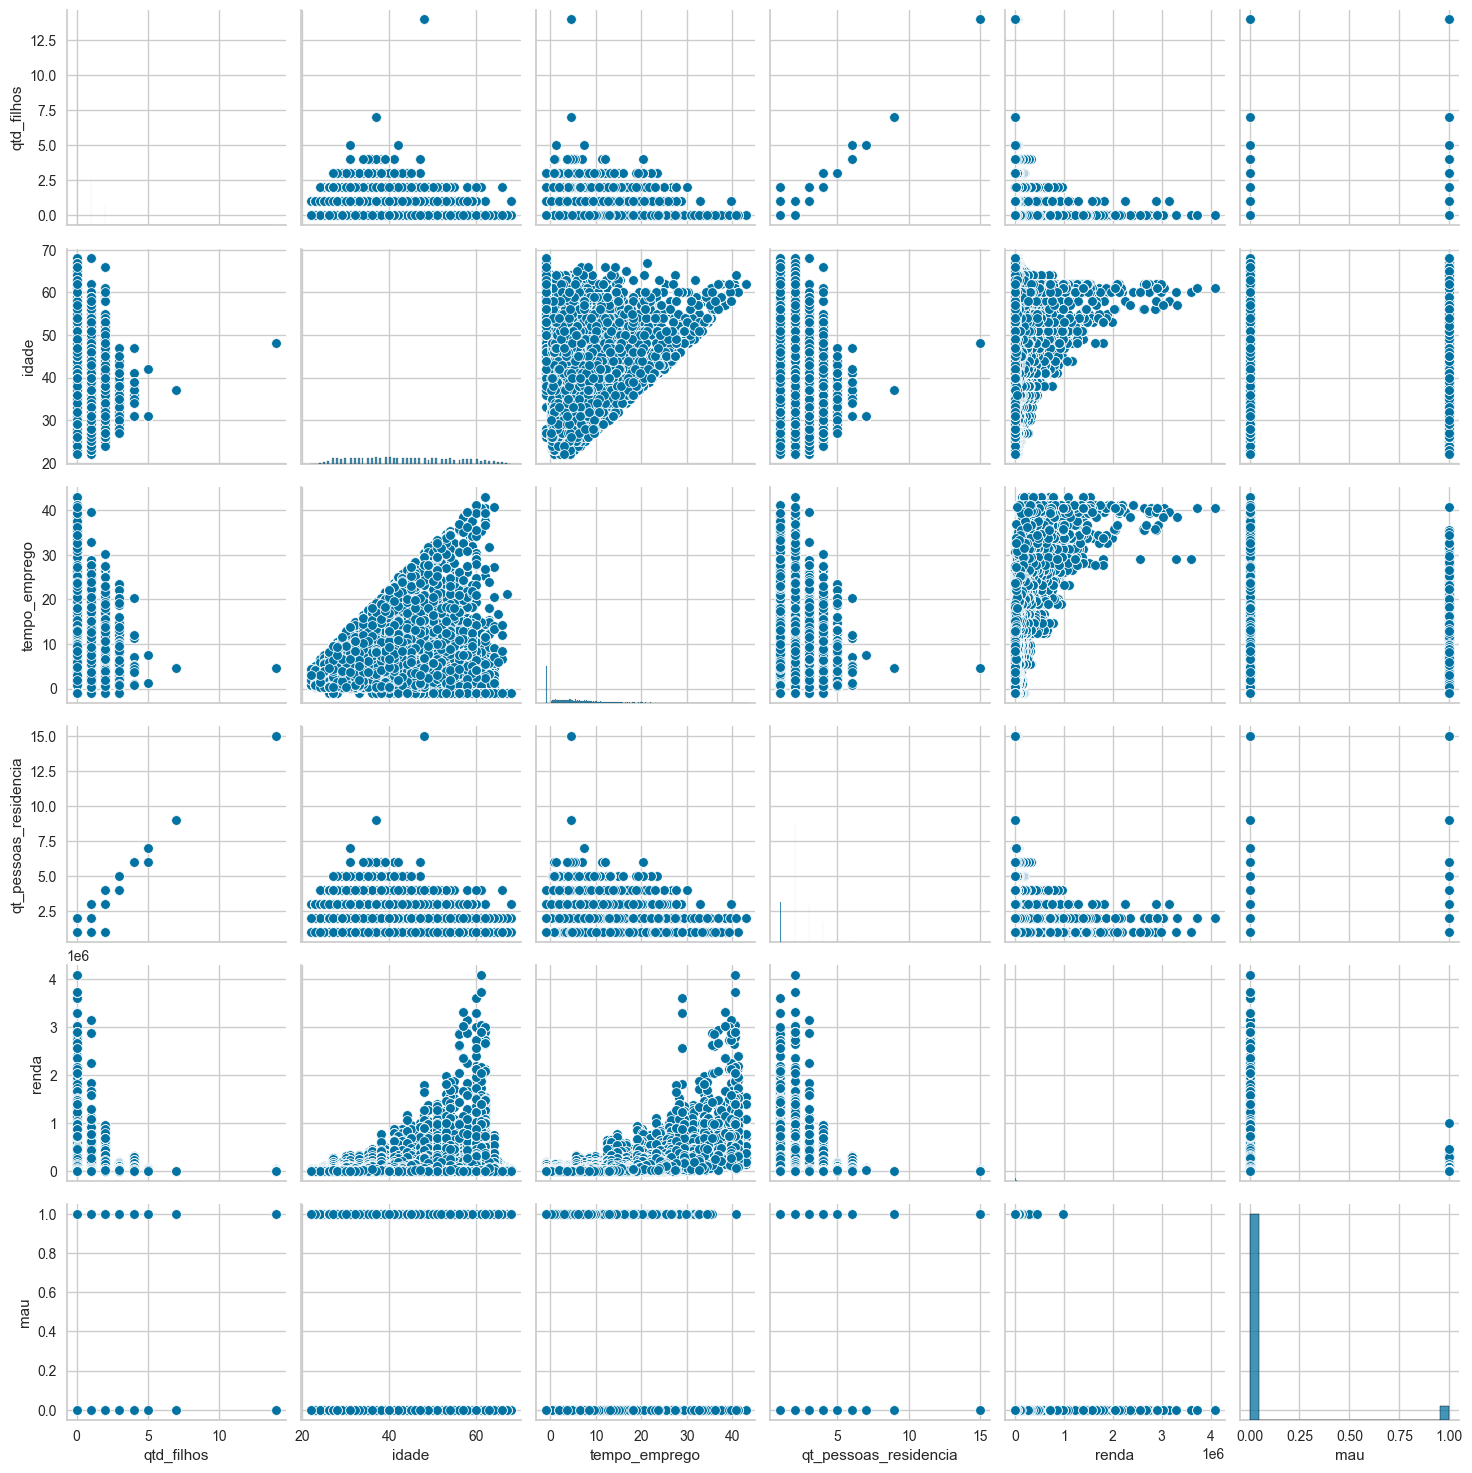

In [11]:
# Plotando gráficos de dispersão para cada par de variáveis quantitativas
sns.pairplot(data=df.fillna({'tempo_emprego': -1}))

plt.show()

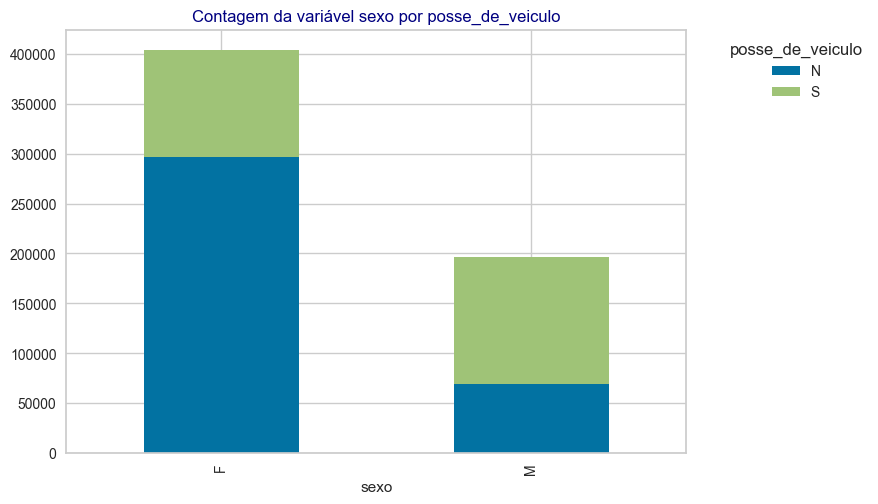

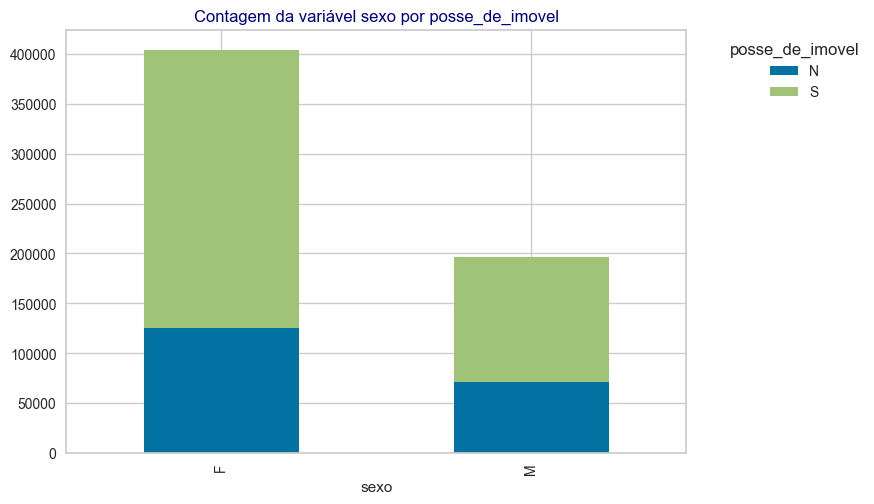

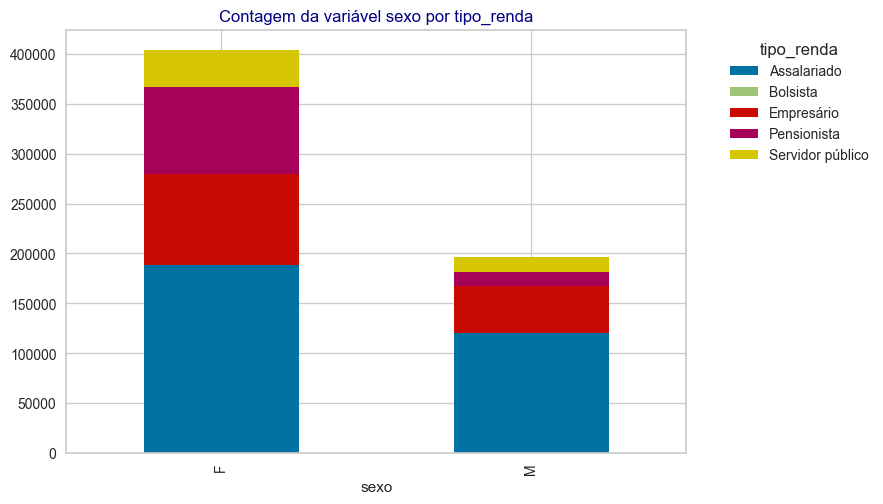

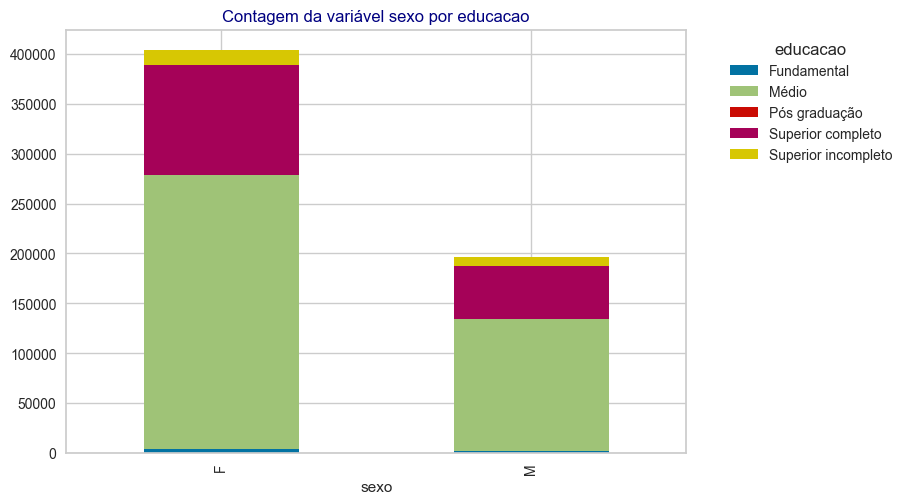

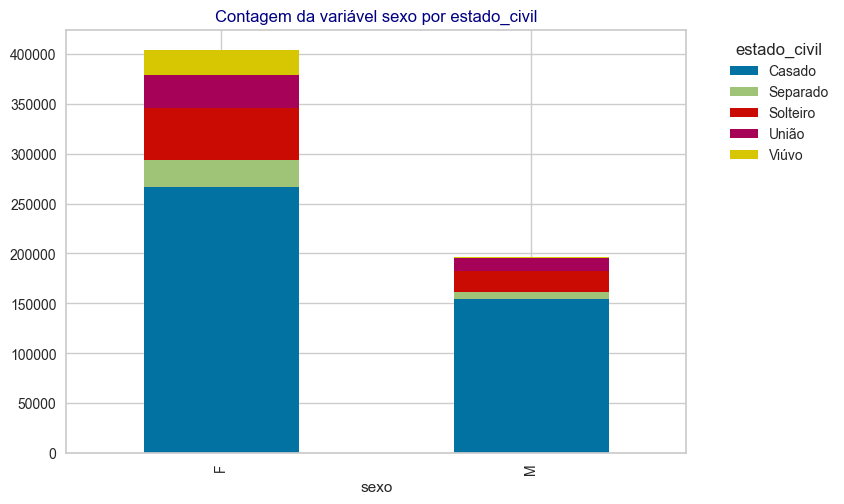

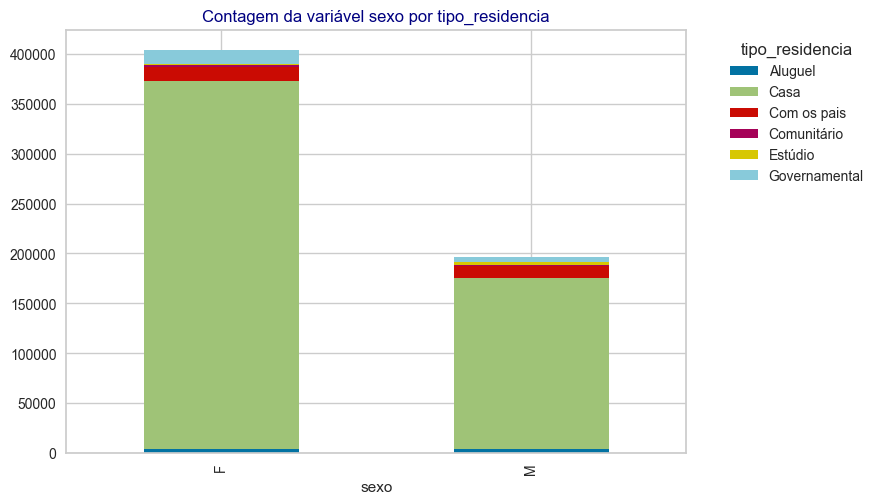

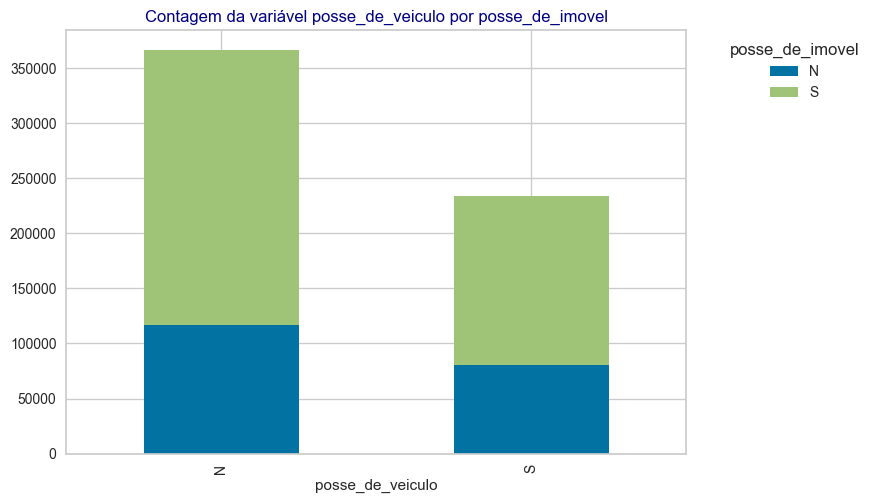

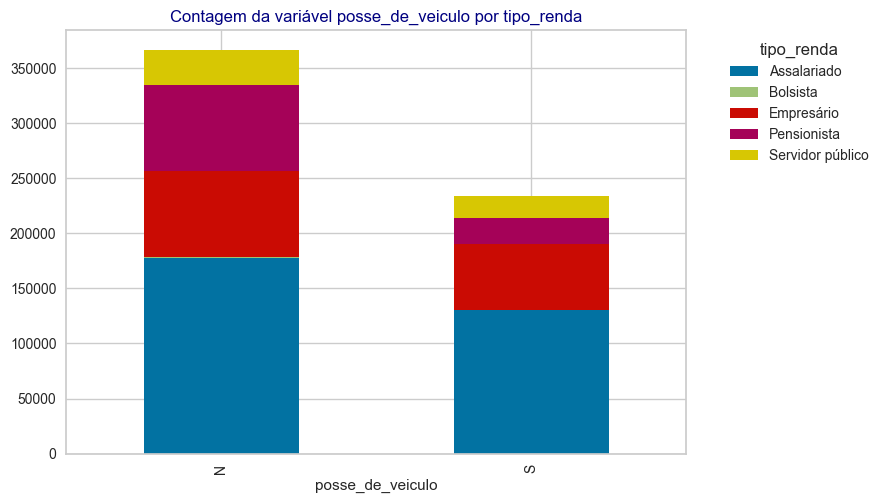

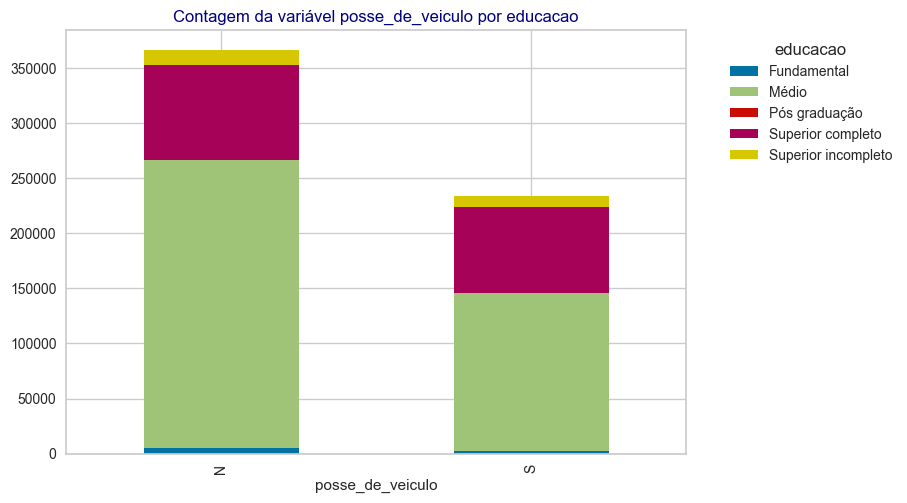

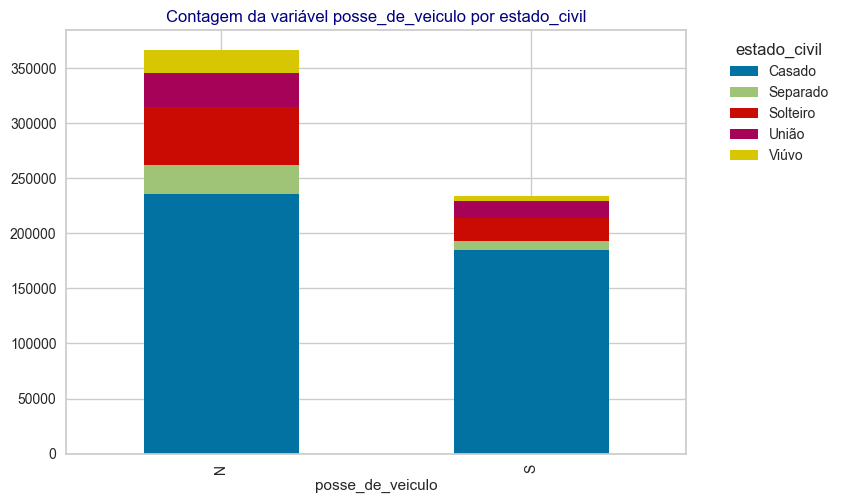

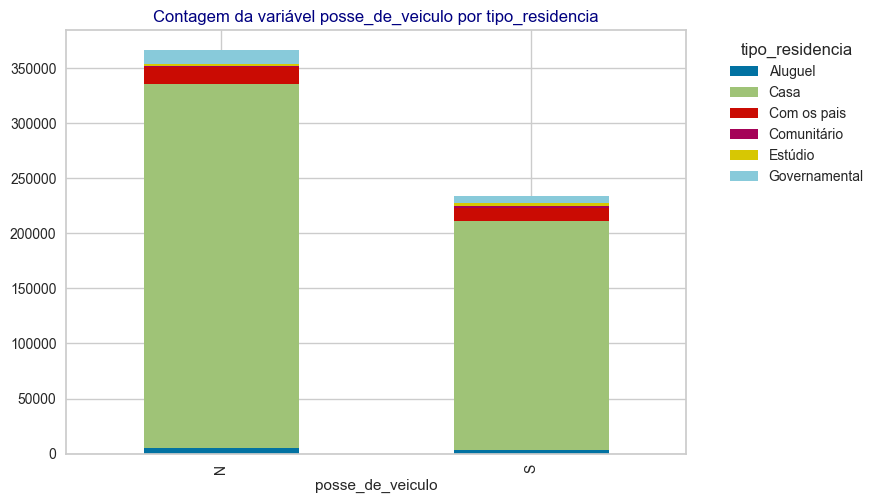

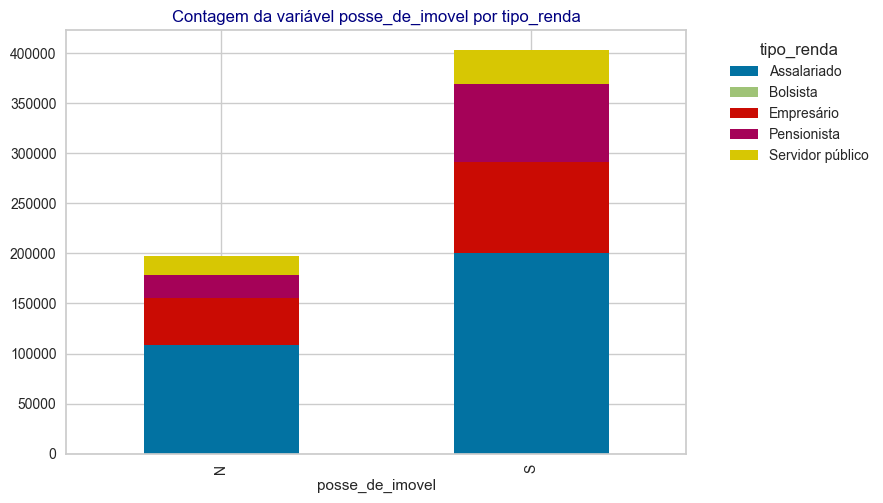

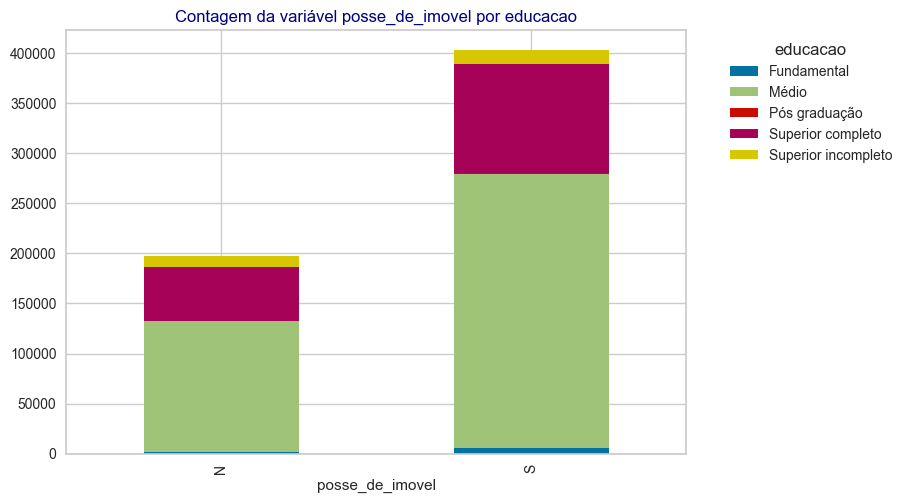

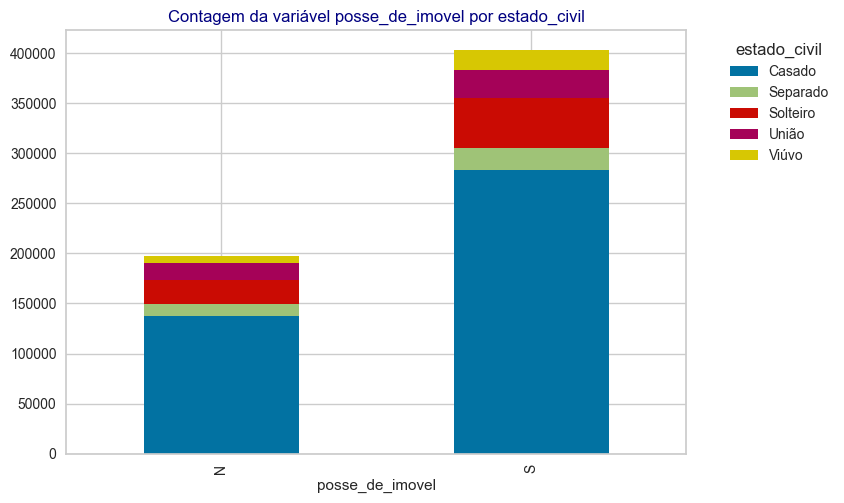

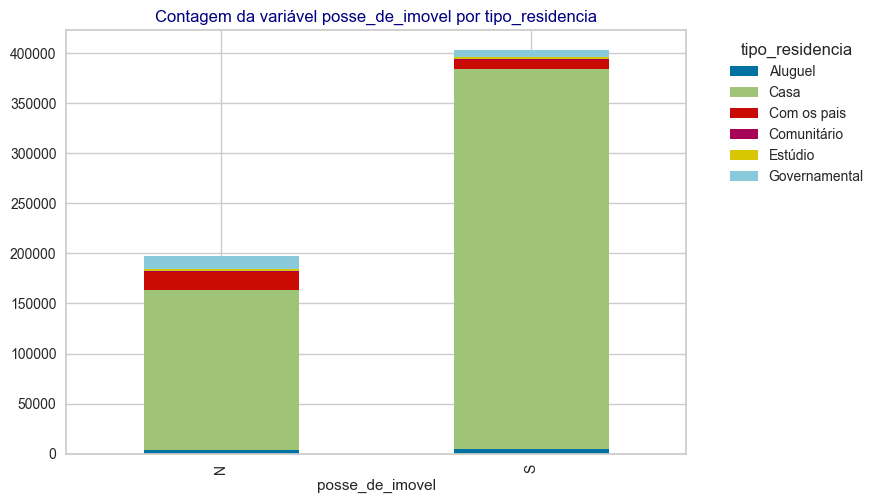

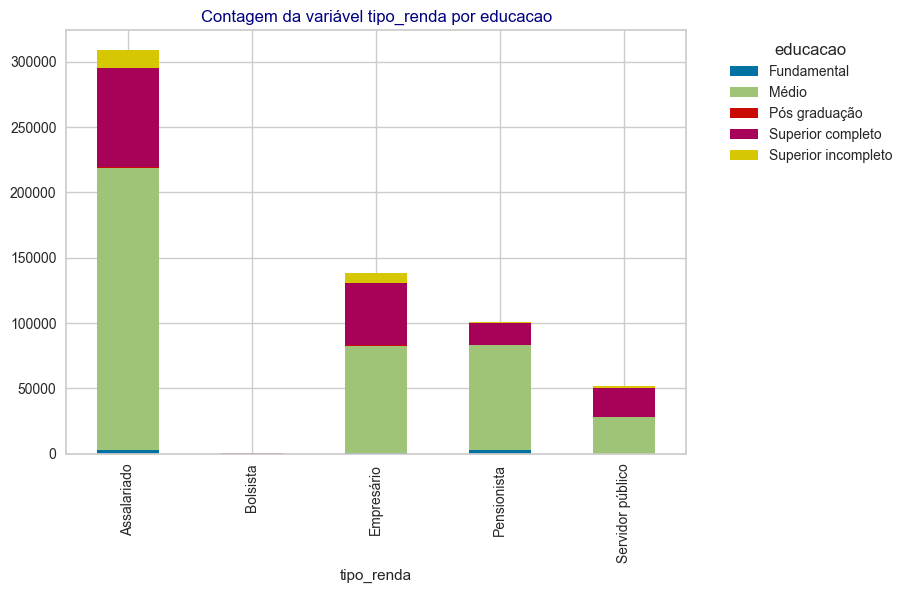

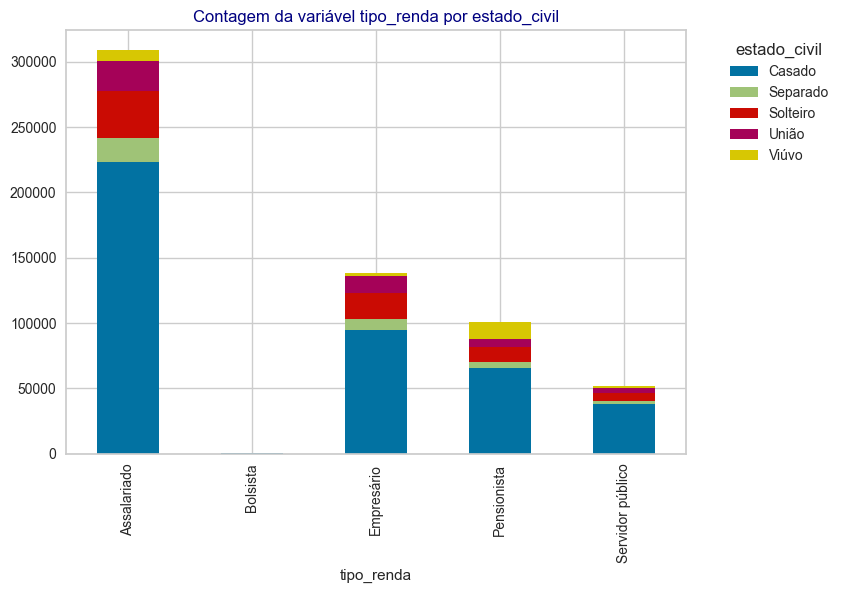

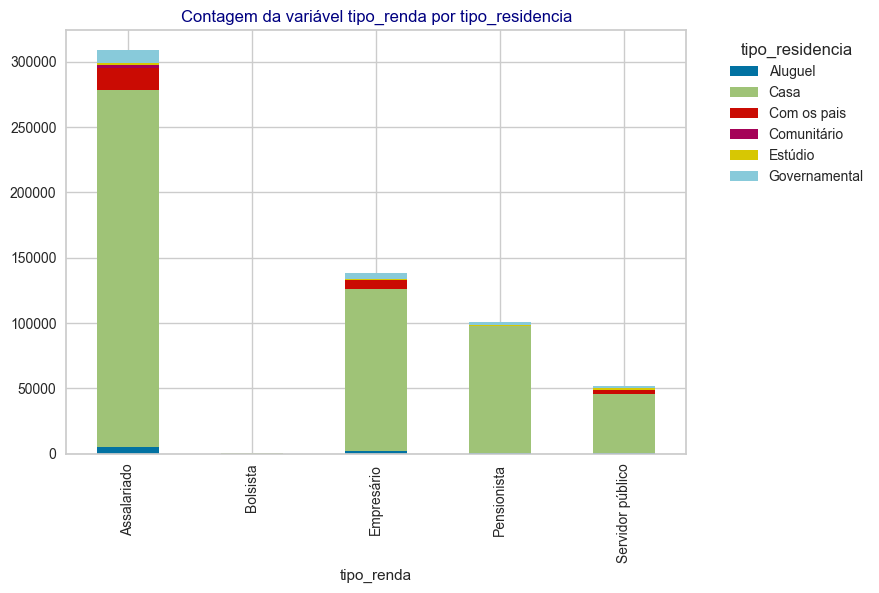

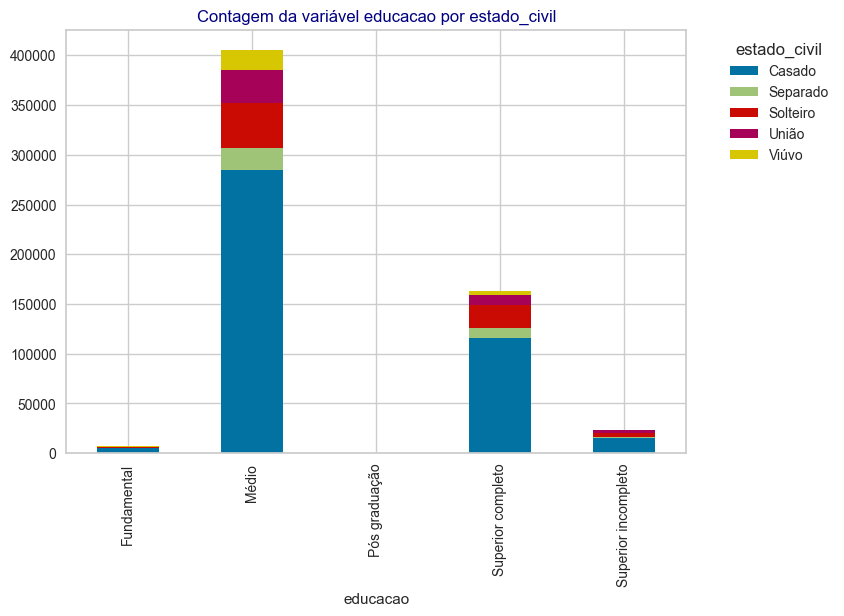

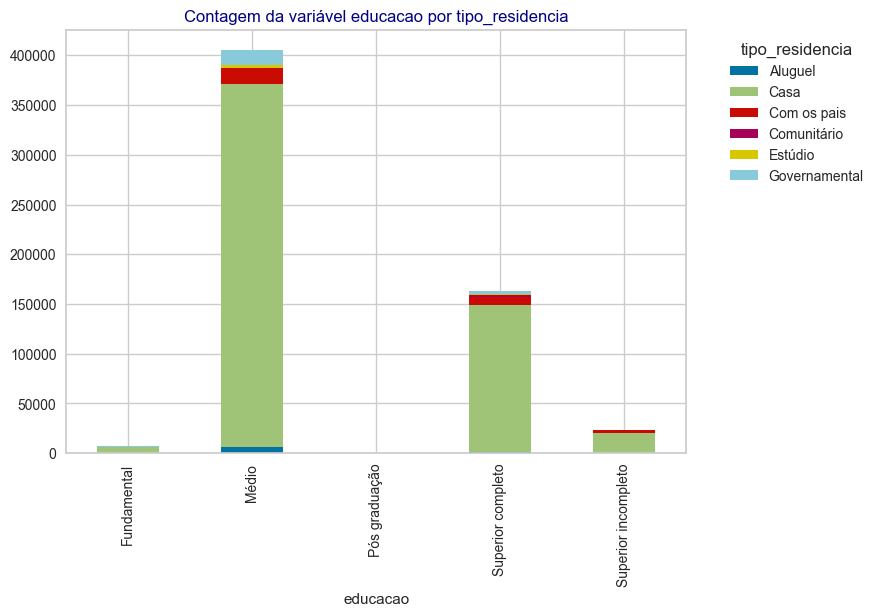

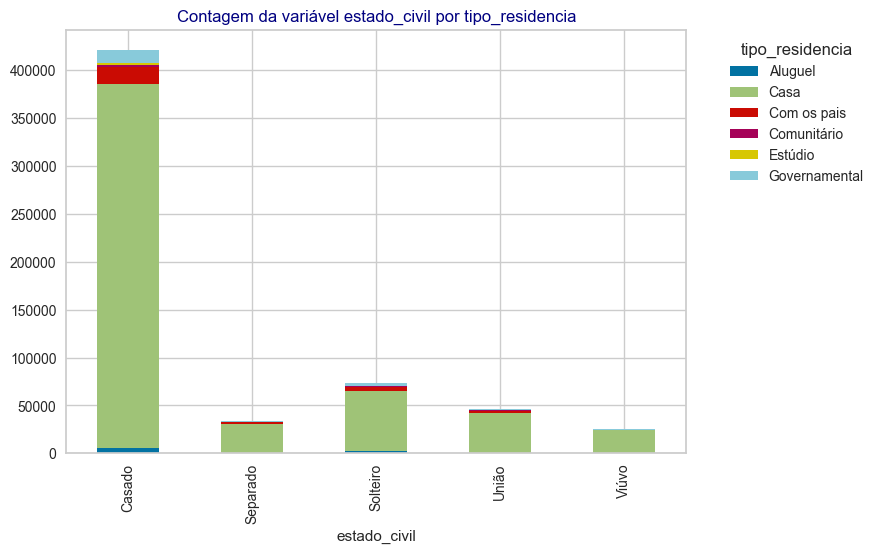

In [12]:
# Plotando gráficos de barras empilhadas para cada par de variáveis qualitativas

qual_vars = df.select_dtypes(include='object').columns

for i in range(len(qual_vars)):
    for j in range(i+1, len(qual_vars)):
        ct = pd.crosstab(df[qual_vars[i]], df[qual_vars[j]])
        ax = ct.plot.bar(stacked=True)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=qual_vars[j])
        ax.set_title(f'Contagem da variável {qual_vars[i]} por {qual_vars[j]}', color='navy')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [13]:
# Trate valores missings e outliers

script.analise(df, 'mau')

,dtype,contagem,missing,nunique,papel
sexo,object,600000,0,2,covariavel
posse_de_veiculo,object,600000,0,2,covariavel
posse_de_imovel,object,600000,0,2,covariavel
qtd_filhos,int64,600000,0,8,covariavel
tipo_renda,object,600000,0,5,covariavel
educacao,object,600000,0,5,covariavel
estado_civil,object,600000,0,5,covariavel
tipo_residencia,object,600000,0,6,covariavel
idade,int64,600000,0,47,covariavel
tempo_emprego,float64,499125,100875,3004,covariavel


In [14]:
# Trate valores missings e outliers

df.fillna({'tempo_emprego': -1}, inplace=True)
script.analise(df, 'mau')

,dtype,contagem,missing,nunique,papel
sexo,object,600000,0,2,covariavel
posse_de_veiculo,object,600000,0,2,covariavel
posse_de_imovel,object,600000,0,2,covariavel
qtd_filhos,int64,600000,0,8,covariavel
tipo_renda,object,600000,0,5,covariavel
educacao,object,600000,0,5,covariavel
estado_civil,object,600000,0,5,covariavel
tipo_residencia,object,600000,0,6,covariavel
idade,int64,600000,0,47,covariavel
tempo_emprego,float64,600000,0,3005,covariavel


In [15]:
# Tratamento de 'zeros estruturais'
# Substituindo os 'zeros estruturais' pela mediana
for col in df.select_dtypes(include=[np.number]).columns:
    median = df.loc[df[col] != 0, col].median()
    df[col] = np.where(df[col] == 0, median, df[col])

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 2607.0]",52717,13951,0.209261,1717.381145,66668,0.001575,0.212349,0.206173,-1.329387,-1.310826,-1.348150,1.403304,1.421865,1.384541
"(2607.0, 4238.0]",59647,7020,0.105299,3416.169087,66667,0.001189,0.107629,0.102969,-2.139681,-2.115187,-2.164657,0.593010,0.617504,0.568034
"(4238.0, 6103.0]",61729,4942,0.074125,5140.692328,66671,0.001015,0.076114,0.072137,-2.524984,-2.496360,-2.554323,0.207707,0.236331,0.178368
"(6103.0, 8445.0]",63178,3484,0.052264,7222.347120,66662,0.000862,0.053953,0.050574,-2.897775,-2.864176,-2.932417,-0.165084,-0.131485,-0.199726
"(8445.0, 11599.0]",63938,2730,0.040949,9933.064749,66668,0.000768,0.042454,0.039445,-3.153612,-3.115965,-3.192608,-0.420921,-0.383274,-0.459917
"(11599.0, 16167.0]",64702,1972,0.029577,13696.583023,66674,0.000656,0.030863,0.028291,-3.490744,-3.446857,-3.536521,-0.758053,-0.714166,-0.803830
"(16167.0, 24155.0]",65311,1347,0.020208,19734.289391,66658,0.000545,0.021276,0.019139,-3.881281,-3.828678,-3.936680,-1.148589,-1.095987,-1.203989
"(24155.0, 44712.0]",65797,877,0.013154,32415.774171,66674,0.000441,0.014018,0.012289,-4.317823,-4.253269,-4.386707,-1.585131,-1.520578,-1.654016
"(44712.0, 4083986.0]",66338,320,0.004801,151746.443037,66658,0.000268,0.005325,0.004276,-5.334197,-5.229937,-5.450476,-2.601506,-2.497246,-2.717785


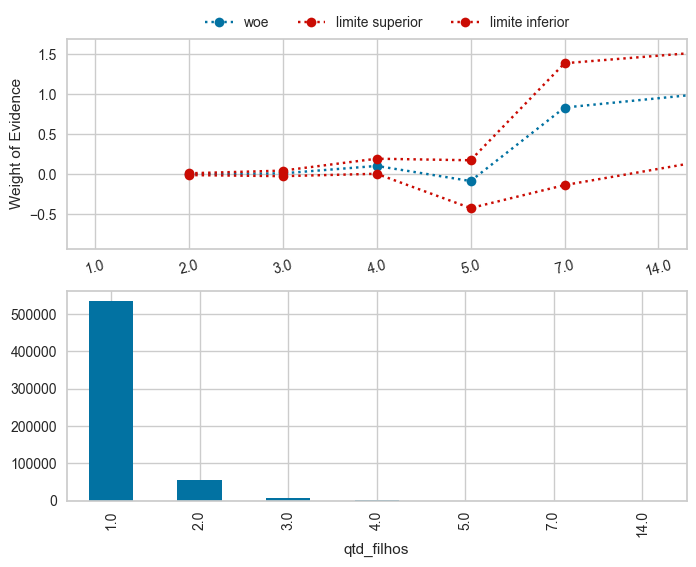

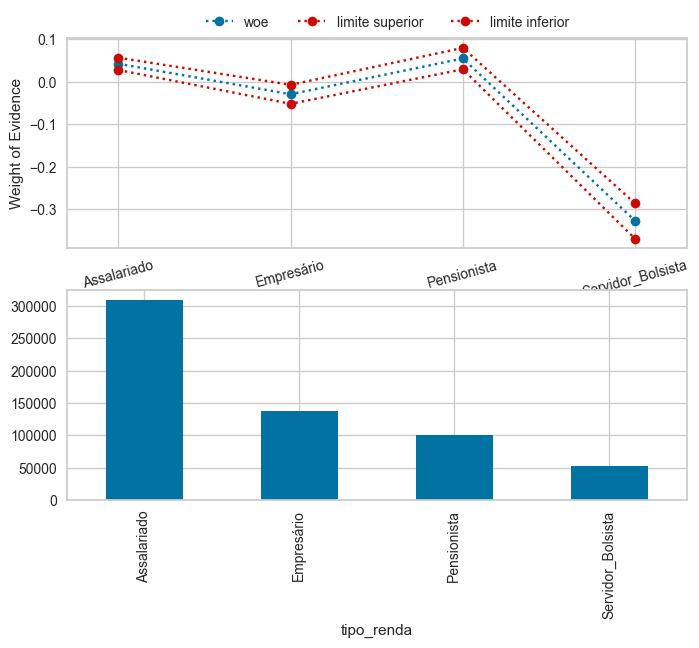

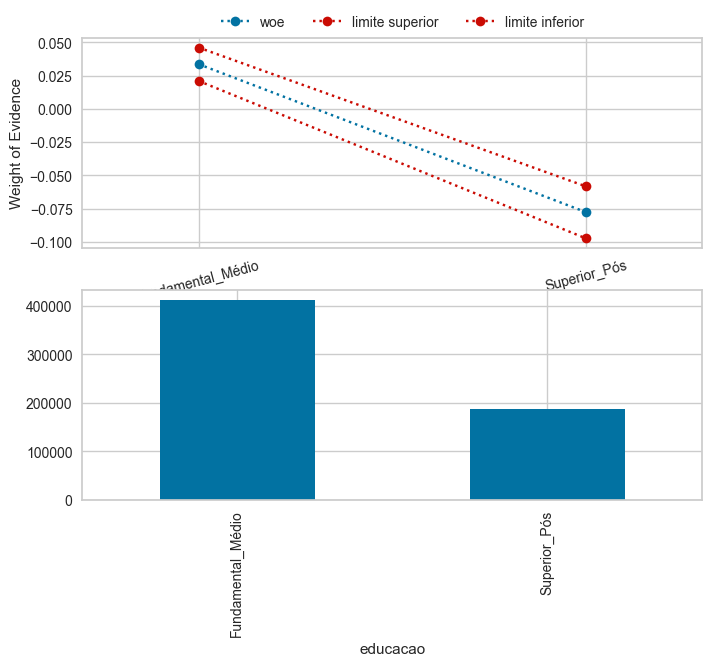

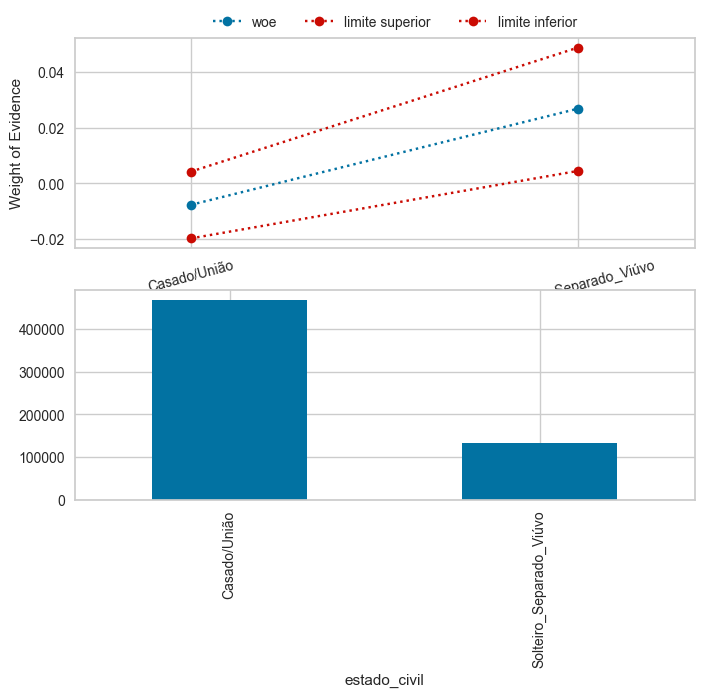

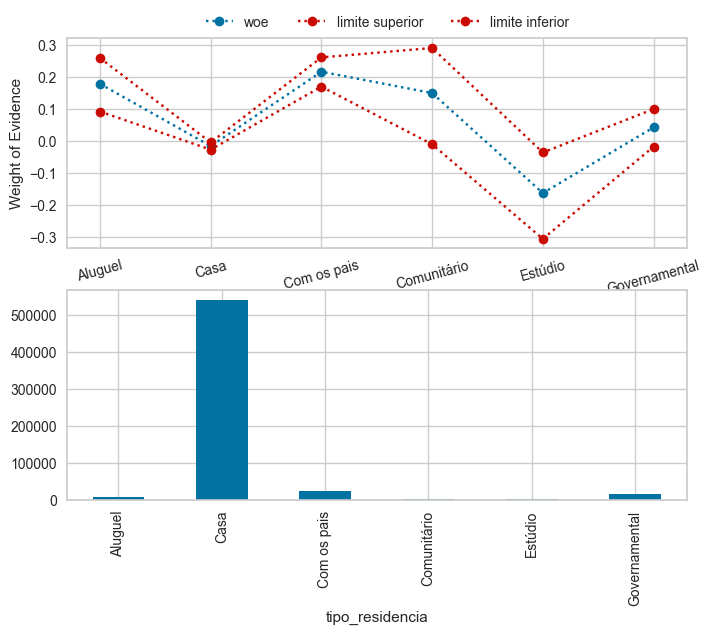

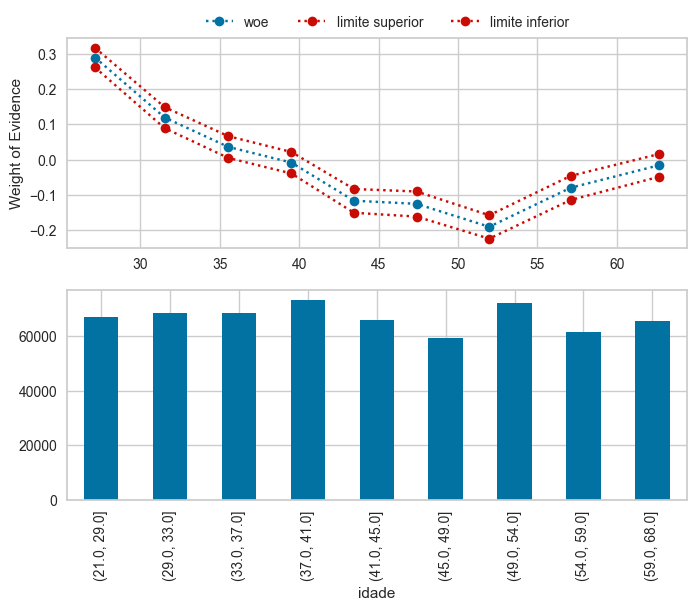

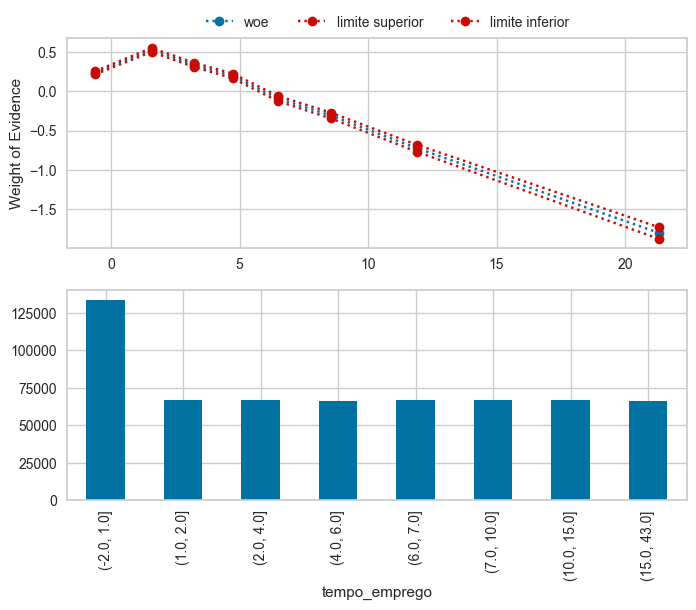

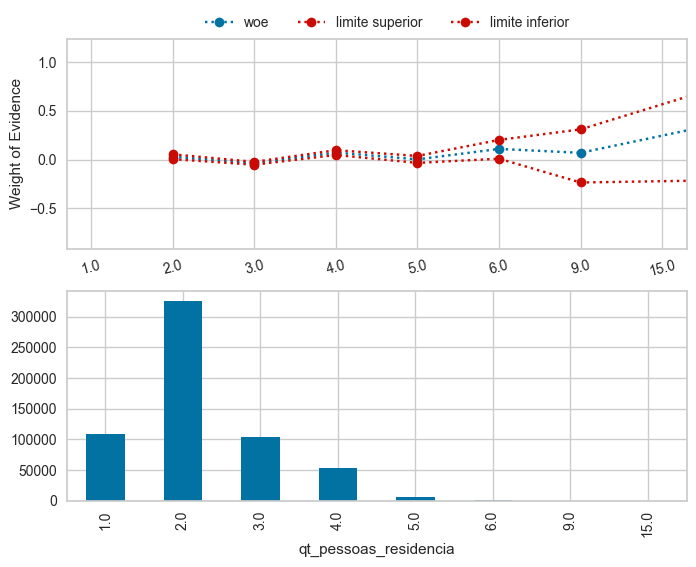

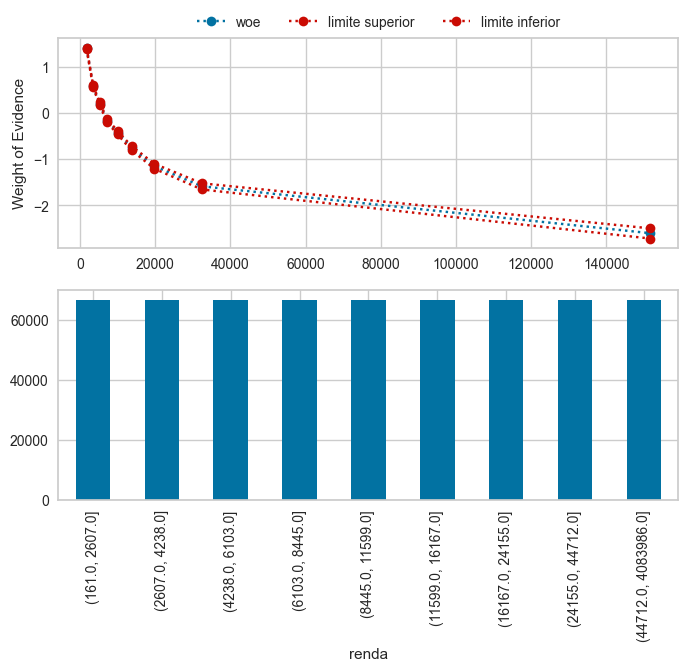

In [16]:
# Trate 'zeros estruturais'

df2 = df.copy()

df2.replace({'tipo_renda': {'Bolsista': 'Servidor_Bolsista', 'Servidor público': 'Servidor_Bolsista'}}, inplace=True)
df2.replace({'estado_civil': {'Solteiro': 'Solteiro_Separado_Viúvo', 'Separado': 'Solteiro_Separado_Viúvo', 'Viúvo': 'Solteiro_Separado_Viúvo', 'Casado': 'Casado/União', 'União': 'Casado/União'}}, inplace=True)
df2.replace({'educacao': {'Fundamental':'Fundamental_Médio', 'Médio': 'Fundamental_Médio', 'Pós graduação': 'Superior_Pós', 'Superior completo': 'Superior_Pós', 'Superior incompleto': 'Superior_Pós'}}, inplace=True)
df2.replace({'qt_pessoas_residencia': {7: 9}}, inplace=True)

script.biv_discreta('qtd_filhos',df2)
script.biv_discreta('tipo_renda',df2)
script.biv_discreta('educacao',df2)
script.biv_discreta('estado_civil',df2)
script.biv_discreta('tipo_residencia',df2)
script.biv_continua('idade', 9, df2)
script.biv_continua('tempo_emprego', 9, df2)
script.biv_discreta('qt_pessoas_residencia',df2)
script.biv_continua('renda', 9, df2)

In [17]:
# Proponha uma equação preditiva para 'mau'

df_final = df2.copy()

df_final = pd.get_dummies(df_final, drop_first=True, dtype='int')
df_final['mau'] = df_final['mau'].map({False: 0, True: 1})
df_final.drop(columns=['bom'], inplace=True)
df_final.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor_Bolsista,educacao_Superior_Pós,estado_civil_Solteiro_Separado_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,
Jan_2015,1.0,43.0,6.873973,1.0,2515.39,0,0,0,0,1,0,0,0,1,1,0,0,0,0
Jan_2015,1.0,35.0,4.526027,2.0,3180.19,0,0,1,1,0,0,0,0,0,1,0,0,0,0
Jan_2015,2.0,31.0,0.243836,4.0,1582.29,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Jan_2015,1.0,54.0,12.772603,2.0,13721.17,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Jan_2015,1.0,31.0,8.432877,1.0,2891.08,0,0,1,0,0,0,0,1,1,1,0,0,0,0


In [18]:
X = df_final.drop(columns='mau')
y = df_final['mau']

df_final_train , df_final_test = train_test_split(df_final, test_size=.2, random_state=42)
df_final_test.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor_Bolsista,educacao_Superior_Pós,estado_civil_Solteiro_Separado_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,
Jan_2015,1.0,41.0,5.531507,2.0,2318.98,0,0,0,1,0,0,0,0,0,1,0,0,0,0
Fev_2015,1.0,57.0,-1.000000,1.0,2249.90,1,0,0,1,0,1,0,0,1,1,0,0,0,0
Ago_2015,1.0,30.0,5.460274,3.0,26575.86,0,0,1,1,1,0,0,1,0,1,0,0,0,0
Jan_2015,2.0,35.0,13.186301,4.0,9270.73,0,1,1,1,0,0,0,0,0,1,0,0,0,0
Out_2015,1.0,22.0,1.846575,2.0,14709.86,0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [19]:
# Proponha uma equação preditiva para 'mau'

X = df_final.drop(columns='mau')
y = df_final['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

scaler = StandardScaler()

parametros = {
    'n_estimators': 300,
    'learning_rate': .3,
    'random_state': 22
}

modelo = XGBClassifier(**parametros)

In [20]:
# Proponha uma equação preditiva para 'mau'

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Proponha uma equação preditiva para 'mau'

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia: {accuracy:.2%}')

Acurácia: 93.71%


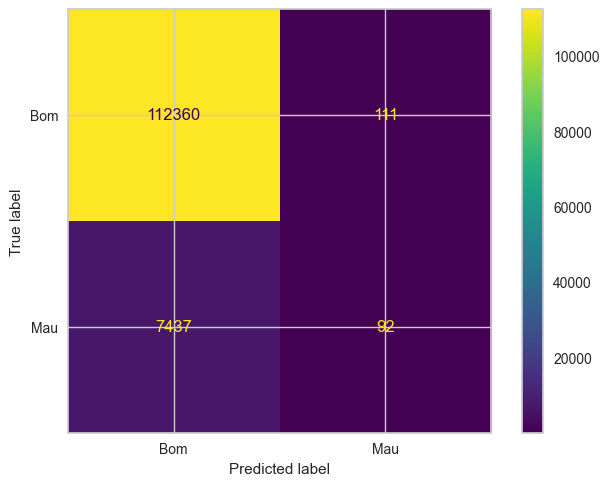

In [22]:
# Proponha uma equação preditiva para 'mau'

cm = metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)
cmd = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bom', 'Mau'])

cmd.plot()

O modelo errou grande parte das preditivas 'Mau', isso indica um problema com o modelo preditivo que criamos.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [23]:
# Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

df_test = pd.DataFrame(X_test, columns=df_final.drop(columns='mau').columns)
df_test['mau'] = y_test.reset_index(drop=True)
df_test.set_index(y_test.index, inplace=True)
df_test

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor_Bolsista,educacao_Superior_Pós,estado_civil_Solteiro_Separado_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental,mau
data_ref,,,,,,,,,,,,,,,,,,,
Jan_2015,-0.304518,-0.249211,-0.108329,-0.234663,-0.286153,-0.697562,-0.798876,0.699622,-0.546352,-0.449891,-0.308189,-0.674664,-0.532884,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0
Fev_2015,-0.304518,1.175977,-1.051641,-1.340421,-0.286948,-0.697562,-0.798876,0.699622,-0.546352,2.222761,-0.308189,-0.674664,1.876583,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,1
Ago_2015,-0.304518,-1.229028,-0.118617,0.871096,-0.007147,-0.697562,1.251759,0.699622,1.830320,-0.449891,-0.308189,1.482219,-0.532884,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0
Jan_2015,2.169857,-0.783657,0.997213,1.976854,-0.206193,1.433564,1.251759,0.699622,-0.546352,-0.449891,-0.308189,-0.674664,-0.532884,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0
Out_2015,-0.304518,-1.941622,-0.640525,-0.234663,-0.143632,-0.697562,-0.798876,0.699622,-0.546352,-0.449891,-0.308189,1.482219,-0.532884,-2.983795,4.634233,-0.066226,-0.085098,-0.179432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mai_2015,-0.304518,-1.139954,-0.081819,0.871096,-0.053910,-0.697562,-0.798876,0.699622,-0.546352,-0.449891,-0.308189,-0.674664,-0.532884,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0
Mai_2015,-0.304518,-0.338285,1.423761,-1.340421,0.517246,1.433564,-0.798876,0.699622,1.830320,-0.449891,-0.308189,-0.674664,1.876583,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0
Dez_2015,-0.304518,0.819680,-0.479482,-0.234663,-0.254754,-0.697562,1.251759,0.699622,-0.546352,-0.449891,3.244763,1.482219,-0.532884,0.335144,-0.215785,-0.066226,-0.085098,-0.179432,0


In [24]:
df_test.loc[:,'classe_predita'] = modelo.predict(X_test)
df_test.loc[:,'PD'] = modelo.predict_proba(X_test)[:, 1]

print('Performance do GBM nos dados de teste')
script.print_metricas(dados=df_test)

Performance do GBM nos dados de teste
KS:       37.34%
AUC:      75.50%
GINI:     51.00%
Acurácia: 93.71%



- **Acurária:** 93,69%, o modelo apresentou uma acurácia boa apesar da análise do Confusion Matrix ter sido ruim.
- **KS:** 37,45%, o modelo não apresentou um KS bom, ainda pode melhorar.
- **AUC:** 75,48, o modelo apresentou um AUC satistatório (Acima de 0.5)
- **GINI:** 50,95%, o modelo apresentou um GINI melhor que o KS, mas dá para melhorar.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [25]:
df = pd.read_feather('credit_scoring.ftr')
df.set_index(keys='data_ref', inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.drop(columns='index', inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [26]:
def remove_nulls(df):
    df.fillna(value=-1, inplace=True)
    return df

script.analise(df, 'mau')

,dtype,contagem,missing,nunique,papel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel
tempo_emprego,float64,624043,125957,3004,covariavel


In [27]:
# Existe nulos na base? é dado numérico ou categórico? *Númerico('tempo_emprego')*
# Qual o valor de substituição? média? valor mais frequente? etc *Optei pelo valor de -1, por supor que os nulos são pessoas sem emprego*

df = remove_nulls(df)
script.analise(df, 'mau')

,dtype,contagem,missing,nunique,papel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel
tempo_emprego,float64,750000,0,3005,covariavel


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [28]:
# Como identificar outlier? *Com o modelo LocalOutlierFactor do sklearn*
# Substituir o outlier por algum valor? Remover a linha? *Optei por remover*
def remove_outliers(df):
    outlier_factor = LocalOutlierFactor()

    # Detecta os outliers
    outliers = outlier_factor.fit_predict(df.select_dtypes(include='number'))

    # Filtra os dados mantendo apenas os não-outliers
    df_sem_outliers = df[outliers != -1]

    return df_sem_outliers

df_sem_outliers = remove_outliers(df)

print(f'\033[1;92mDF_SEM_OUTLIERS:\033[0;1m\n{df_sem_outliers["mau"].value_counts()}\n')
print(f'\033[1;92mDF:\033[0;1m\n{df["mau"].value_counts()}')

DF_SEM_OUTLIERS:
mau
False    675070
True      57685
Name: count, dtype: int64

DF:
mau
False    691357
True      58643
Name: count, dtype: int64


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [29]:
# Qual tipo de técnica? Boruta? Feature importance? *IV*

analise_df = script.analise(df_sem_outliers, y='mau')
analise_df

for var in analise_df[analise_df.papel!='resposta'].index:
    if  (analise_df.loc[var, 'nunique']>45):
        analise_df.loc[var, 'IV'] = script.IV(pd.qcut(df_sem_outliers[var],15,duplicates='drop'), df_sem_outliers.mau)
    else: 
        analise_df.loc[var, 'IV'] = script.IV(df_sem_outliers[var], df_sem_outliers.mau)
    
analise_df.sort_values(by='IV', ascending=False, inplace=True)
analise_df

,dtype,contagem,missing,nunique,papel,IV
qt_pessoas_residencia,float64,732755,0,8,covariavel,inf
renda,float64,732755,0,138159,covariavel,1.183227
tempo_emprego,float64,732755,0,3005,covariavel,0.309669
idade,int64,732755,0,47,covariavel,0.020797
posse_de_imovel,object,732755,0,2,covariavel,0.009623
tipo_renda,object,732755,0,5,covariavel,0.009221
educacao,object,732755,0,5,covariavel,0.003526
tipo_residencia,object,732755,0,6,covariavel,0.002921
sexo,object,732755,0,2,covariavel,0.002442
qtd_filhos,int64,732755,0,7,covariavel,0.001238


In [30]:
print(f'\033[1;7mInformation Value (IV):\033[0m\n{"-"*36}')

for i, j in zip(analise_df.index, analise_df.IV):
    if j > 0.5:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Suspeito de tão alto)\033[0m\n{"-"*36}')
    elif j > 0.3:
        print(f'\033[1m{i}:\033[0m\033[1;94m {j:.3f} (Forte)\033[0m\n{"-"*36}')
    elif j > 0.1:
        print(f'\033[1m{i}:\033[0m\033[1;92m {j:.3f} (Médio)\033[0m\n{"-"*36}')
    elif j > 0.02:
        print(f'\033[1m{i}:\033[0m\033[1;93m {j:.3f} (Fraco)\033[0m\n{"-"*36}')
    else:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Inútil)\033[0m\n{"-"*36}')

Information Value (IV):
------------------------------------
qt_pessoas_residencia: inf (Suspeito de tão alto)
------------------------------------
renda: 1.183 (Suspeito de tão alto)
------------------------------------
tempo_emprego: 0.310 (Forte)
------------------------------------
idade: 0.021 (Fraco)
------------------------------------
posse_de_imovel: 0.010 (Inútil)
------------------------------------
tipo_renda: 0.009 (Inútil)
------------------------------------
educacao: 0.004 (Inútil)
------------------------------------
tipo_residencia: 0.003 (Inútil)
------------------------------------
sexo: 0.002 (Inútil)
------------------------------------
qtd_filhos: 0.001 (Inútil)
------------------------------------
estado_civil: 0.001 (Inútil)
------------------------------------
posse_de_veiculo: 0.000 (Inútil)
------------------------------------
mau: nan (Inútil)
------------------------------------


**IV:** Vemos que pela análise do IV as melhores variáveis para se utilizar são *"tempo_emprego"* e *"idade"*, porém pode-se considerar utilizar a variável *"renda"* também.

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [31]:
def pca(df, target, n_components=None):
    X = df.drop(columns=target)
    y = df[target]

    pca = PCA(n_components=n_components)

    pca.fit_transform(X.select_dtypes(include='number'))

    df = pd.DataFrame(pca.transform(X.select_dtypes(include='number')), index=X.index)

    df['mau'] = y

    return df

teste = pca(df, 'mau')
teste

,0,1,2,3,4,mau
data_ref,,,,,,
Jan_2015,-20723.154714,0.608635,-1.381121,-1.262489,0.409154,False
Jan_2015,-20058.354927,8.348619,1.815494,-0.750418,-0.229964,False
Jan_2015,-21656.255161,11.965047,6.416368,1.939882,0.093436,False
Jan_2015,-9517.374324,-9.567171,-7.926206,-0.113523,-0.177574,False
Jan_2015,-20347.464824,12.701377,-1.660500,-1.709046,0.382711,False
...,...,...,...,...,...,...
Mar_2016,-21128.554800,-4.737545,1.890009,-0.268343,-0.201026,False
Mar_2016,-21849.154719,-22.089490,4.100986,-0.408888,0.452190,False
Mar_2016,-22589.484571,1.087196,-4.954112,2.304390,0.132734,True


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [32]:
def dummies(df=None, columns=None):
    df = pd.get_dummies(df, drop_first=True, dtype='int', columns=columns)
    return df
script.analise(dummies(df), 'mau')

,dtype,contagem,missing,nunique,papel
qtd_filhos,int64,750000,0,8,covariavel
idade,int64,750000,0,47,covariavel
tempo_emprego,float64,750000,0,3005,covariavel
qt_pessoas_residencia,float64,750000,0,9,covariavel
renda,float64,750000,0,142419,covariavel
mau,bool,750000,0,2,resposta
sexo_M,int32,750000,0,2,covariavel
posse_de_veiculo_S,int32,750000,0,2,covariavel
posse_de_imovel_S,int32,750000,0,2,covariavel
tipo_renda_Bolsista,int32,750000,0,2,covariavel


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [50]:
# Pipeline

df = pd.read_feather('credit_scoring.ftr')
df.set_index(keys='data_ref', inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.drop(columns='index', inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [51]:
X = df.drop(columns='mau')
y = df['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [62]:
pipe = Pipeline(steps=[('dummy', dummies(df, ['posse_de_veiculo'])),
                       ('missings', remove_nulls(df)),
                       ('outliers', remove_outliers(df)),
                       ('pca', pca(df, 'mau', 5))], )

In [56]:
# dummy

pipe[0].head()

,sexo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,posse_de_veiculo_S
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,0
Jan_2015,F,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
Jan_2015,F,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,0
Jan_2015,F,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,0
Jan_2015,F,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1


In [57]:
# missings

pipe[1].head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [58]:
# outliers

pipe[2].head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [60]:
# pca

pipe[3].head()

,0,1,2,3,4,mau
data_ref,,,,,,
Jan_2015,-20723.154714,0.608635,-1.381121,-1.262489,0.409154,False
Jan_2015,-20058.354927,8.348619,1.815494,-0.750418,-0.229964,False
Jan_2015,-21656.255161,11.965047,6.416368,1.939882,0.093436,False
Jan_2015,-9517.374324,-9.567171,-7.926206,-0.113523,-0.177574,False
Jan_2015,-20347.464824,12.701377,-1.660500,-1.709046,0.382711,False


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [37]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [38]:
#from pycaret.classification import *
#models()

In [39]:
#xxx = create_model('xxx')